In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from tslearn.clustering import TimeSeriesKMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-05-13 22:51:51.486291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
#load data
df = pd.read_excel("Data-Traffic.xlsx")
df.head

<bound method NDFrame.head of      site      0      1      2      3      4      5      6      7      8  ...  \
0    A001  94.74  82.00  66.06  45.93  33.63  34.35  34.86  47.07  66.11  ...   
1    A002  42.50  28.61  18.84  11.92   9.63   8.60  12.40  35.17  57.36  ...   
2    A004  21.28  26.63  14.67   9.99   4.90   5.12   5.59   8.52  15.21  ...   
3    A005  73.77  61.79  44.45  45.26  31.08  34.43  30.58  42.26  56.88  ...   
4    A006  10.72   8.94   6.06   4.25   3.32   2.46   2.97   6.26  12.20  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
738  B594  57.28  41.34  37.40  25.66  17.55  18.00  19.40  24.77  29.38  ...   
739  B595  90.94  90.12  68.81  47.47  29.38  32.57  25.14  65.86  59.21  ...   
740  B596  72.53  63.78  42.95  36.87  21.52  18.28  23.96  36.60  41.40  ...   
741  B598  33.43  24.24  19.10  20.32  14.86  15.15  15.61  19.28  30.47  ...   
742  B599  35.28  25.39  17.92  12.99  10.75   8.66  11.21  22.30  41.84  ...  

In [90]:
#load the clusters
clusters = pd.read_csv("final_cluster_analysis.csv")
clusters = clusters.iloc[:,[0, 1, 6, 8, 10, 12]]
print(clusters.head())

  BS Name        Final Cluster   KMeans Most Common LSTM Most Common  \
0    A001          Residential          Residential            Mixed   
1    A002                Mixed                Mixed            Mixed   
2    A004          Residential          Residential      Residential   
3    A005          Residential          Residential      Residential   
4    A006  Business/Industrial  Business/Industrial            Mixed   

       GRU Most Common      TCN Most Common  
0          Residential                Mixed  
1                Mixed                Mixed  
2          Residential          Residential  
3          Residential          Residential  
4  Business/Industrial  Business/Industrial  


In [91]:
#Merging 
clusters.rename(columns={'BS Name': 'site'}, inplace=True)
merged_data =df.merge(clusters, on='site', how='left')
merged_data.head()

,site,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,Final Cluster,KMeans Most Common,LSTM Most Common,GRU Most Common,TCN Most Common
0,A001,94.74,82.00,66.06,45.93,33.63,34.35,34.86,47.07,66.11,...,89.27,93.80,96.98,102.55,98.26,Residential,Residential,Mixed,Residential,Mixed
1,A002,42.50,28.61,18.84,11.92,9.63,8.60,12.40,35.17,57.36,...,64.08,58.77,71.91,64.69,55.23,Mixed,Mixed,Mixed,Mixed,Mixed
2,A004,21.28,26.63,14.67,9.99,4.90,5.12,5.59,8.52,15.21,...,31.97,30.12,31.01,37.33,33.31,Residential,Residential,Residential,Residential,Residential
3,A005,73.77,61.79,44.45,45.26,31.08,34.43,30.58,42.26,56.88,...,100.15,96.00,95.71,87.17,85.33,Residential,Residential,Residential,Residential,Residential
4,A006,10.72,8.94,6.06,4.25,3.32,2.46,2.97,6.26,12.20,...,23.42,17.78,11.83,13.04,14.79,Business/Industrial,Business/Industrial,Mixed,Business/Industrial,Business/Industrial


In [92]:
# Load pre-labeled data
df = merged_data 

#define hour sets
hour_sets = {
    "Full 0–23": list(range(25)),
    "Reduced 0–1 & 7–23": [1, 2] + list(range(7, 24))
}   
# select numeric columns
numeric_data_full = df.iloc[:, hour_sets["Full 0–23"]].drop(columns=["site"])
numeric_data_reduced = df.iloc[:, hour_sets["Reduced 0–1 & 7–23"]]

# Normalization
scaler = MinMaxScaler()
normalized_data_full = scaler.fit_transform(numeric_data_full.to_numpy())  
normalized_data_reduced = scaler.fit_transform(numeric_data_reduced.to_numpy())  



In [93]:
#Labels
label_mapping = {"Residential": 0, "Mixed": 1, "Business/Industrial": 2}

labels_kmeans = df["KMeans Most Common"].map(label_mapping).values
labels_lstm = df["LSTM Most Common"].map(label_mapping).values
labels_gru = df["GRU Most Common"].map(label_mapping).values
labels_tcn = df["TCN Most Common"].map(label_mapping).values
labels_final_cluster = df["Final Cluster"].map(label_mapping).values

In [95]:
#defining functions to evaluate metrics

def evaluate_clustering(normalized_data, labels, n_clusters=3, label_names=['Residential', 'Business', 'Mixed']):
    average_profiles = {c: normalized_data[np.where(labels == c)[0]].mean(axis=0) for c in range(n_clusters)}
    metrics = {name: np.zeros((n_clusters, n_clusters)) for name in ['MAE', 'RMSE', 'MSE', 'Correlation', 'CosineSimilarity', 'EuclideanDistance']}

    for i in range(n_clusters):
        profiles_i = normalized_data[np.where(labels == i)[0]]
        for j in range(n_clusters):
            avg_j = average_profiles[j]
            mae, rmse, mse, corr, cos, euc = [], [], [], [], [], []
            for p in profiles_i:
                mae.append(mean_absolute_error(p, avg_j))
                rmse.append(np.sqrt(mean_squared_error(p, avg_j)))
                mse.append(mean_squared_error(p, avg_j))
                corr.append(pearsonr(p, avg_j)[0])
                cos.append(np.dot(p, avg_j) / (np.linalg.norm(p) * np.linalg.norm(avg_j)))
                euc.append(np.linalg.norm(p - avg_j))
            metrics['MAE'][i, j] = np.mean(mae)
            metrics['RMSE'][i, j] = np.mean(rmse)
            metrics['MSE'][i, j] = np.mean(mse)
            metrics['Correlation'][i, j] = np.mean(corr)
            metrics['CosineSimilarity'][i, j] = np.mean(cos)
            metrics['EuclideanDistance'][i, j] = np.mean(euc)
    label_order = ['Residential', 'Mixed', 'Business']
    return {k: pd.DataFrame(v, index=label_order, columns=label_order) for k, v in metrics.items()}

def plot_matrices_side_by_side(results_full, results_reduced, metric_name, model_name=None, cmap='coolwarm', label_maps=None):
    default_labels = ["C0", "C1", "C2"]
    if label_maps and model_name:
        labels_full = [label_maps.get(model_name, {}).get("Full 0–23", {}).get(i, f"C{i}") for i in range(3)]
        labels_reduced = [label_maps.get(model_name, {}).get("Reduced 0–1 & 7–23", {}).get(i, f"C{i}") for i in range(3)]
    else:
        labels_full = default_labels
        labels_reduced = default_labels

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(results_full[metric_name], annot=True, fmt=".3f", cmap=cmap,
                xticklabels=labels_full, yticklabels=labels_full, ax=axes[0])
    axes[0].set_title(f"{metric_name} - Full")

    sns.heatmap(results_reduced[metric_name], annot=True, fmt=".3f", cmap=cmap,
                xticklabels=labels_reduced, yticklabels=labels_reduced, ax=axes[1])
    axes[1].set_title(f"{metric_name} - Reduced")

    plt.tight_layout()
    plt.show()


def plot_cluster_profiles(normalized_data, labels, hour_indices, title="Cluster Profiles"):
    n_clusters = len(np.unique(labels))
    plt.figure(figsize=(10, 6))
    
    for cluster in range(n_clusters):
        indices = np.where(labels == cluster)[0]
        cluster_profiles = normalized_data[indices]
        mean_profile = np.mean(cluster_profiles, axis=0)
        plt.plot(hour_indices, mean_profile, label=f"Cluster {cluster}", linewidth=2)
    
    plt.xticks(hour_indices, rotation=45)
    plt.xlabel("Hour")
    plt.ylabel("Normalized")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [98]:
# Results for full 24
results_kmeans_full = evaluate_clustering(normalized_data_full, labels_kmeans)
results_lstm_full = evaluate_clustering(normalized_data_full, labels_lstm)
results_gru_full= evaluate_clustering(normalized_data_full, labels_gru)
results_tcn_full = evaluate_clustering(normalized_data_full, labels_tcn)
results_final_cluster_full = evaluate_clustering(normalized_data_full, labels_final_cluster)

In [99]:
#results for reduced
results_kmeans_reduced = evaluate_clustering(normalized_data_reduced, labels_kmeans)
results_lstm_reduced = evaluate_clustering(normalized_data_reduced, labels_lstm)
results_gru_reduced = evaluate_clustering(normalized_data_reduced, labels_gru)
results_tcn_reduced = evaluate_clustering(normalized_data_reduced, labels_tcn)
results_final_cluster_reduced = evaluate_clustering(normalized_data_reduced, labels_final_cluster)

In [119]:
models = ["LSTM", "KMeans", "GRU", "TCN", "Final Cluster"]  

custom_label_maps = {
    model: {
        "Full 0–23": {i: label_mapping[i] for i in label_mapping.keys()},  # Use correct keys
        "Reduced 0–1 & 7–23": {i: label_mapping[i] for i in label_mapping.keys()}
    }
    for model in models
}


In [104]:
all_results = {
    "KMeans": {
        "Full 0–23": results_kmeans_full,
        "Reduced 0–1 & 7–23": results_kmeans_reduced
    },
    "LSTM": {
        "Full 0–23": results_lstm_full,
        "Reduced 0–1 & 7–23": results_lstm_reduced
    },
    "GRU": {
        "Full 0–23": results_gru_full,
        "Reduced 0–1 & 7–23": results_gru_reduced
    },
    "TCN": {
        "Full 0–23": results_tcn_full,
        "Reduced 0–1 & 7–23": results_tcn_reduced
    },
    "Final Cluster": {
        "Full 0–23": results_final_cluster_full,
        "Reduced 0–1 & 7–23": results_final_cluster_reduced
    }
}


KMEANS - MAE


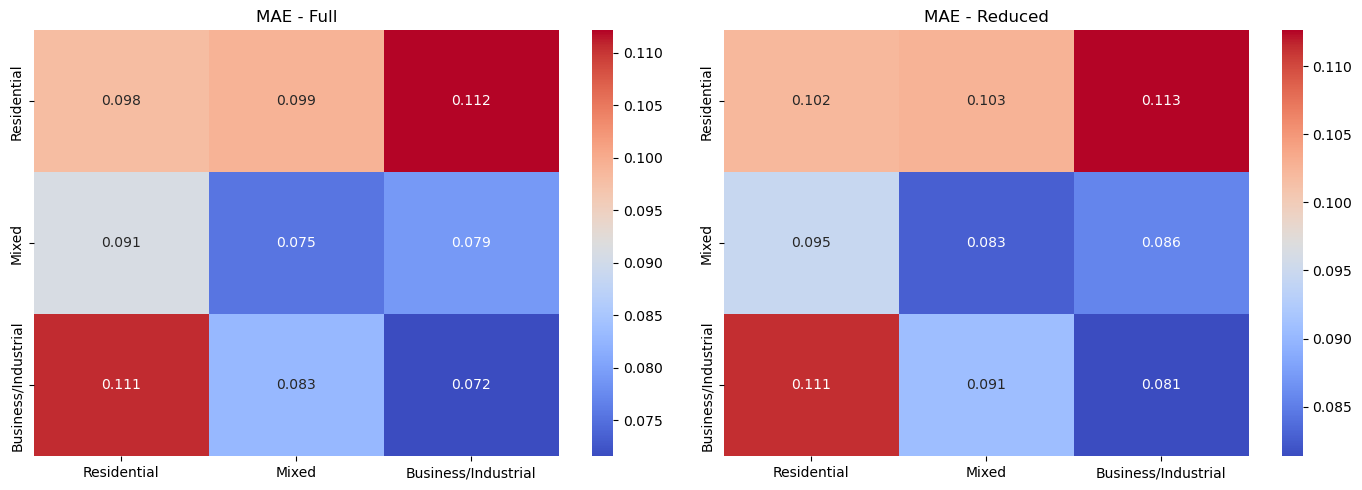

KMEANS - RMSE


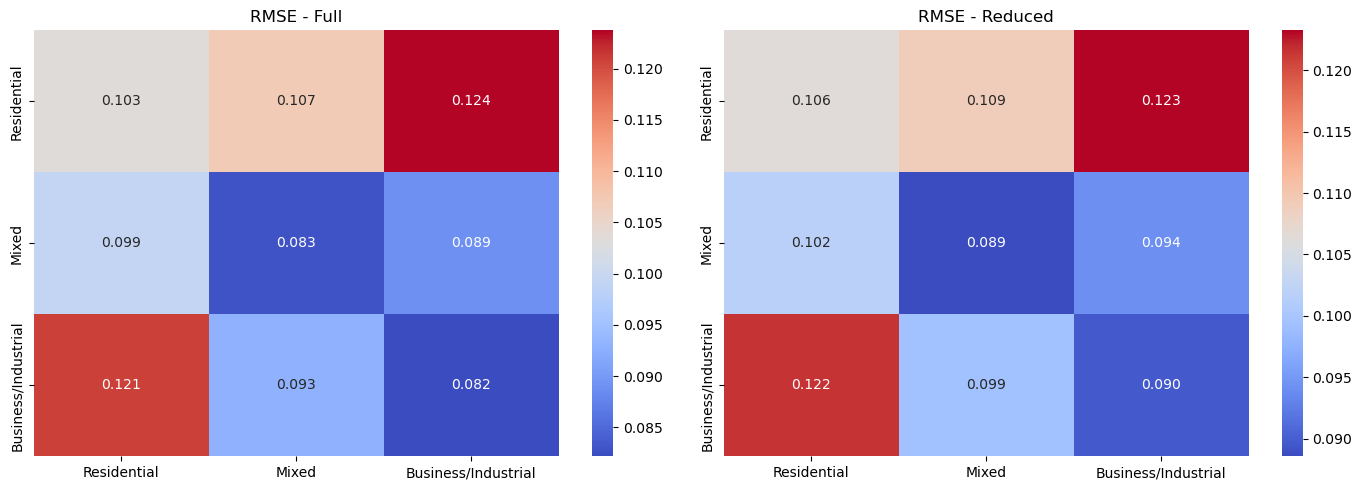

KMEANS - MSE


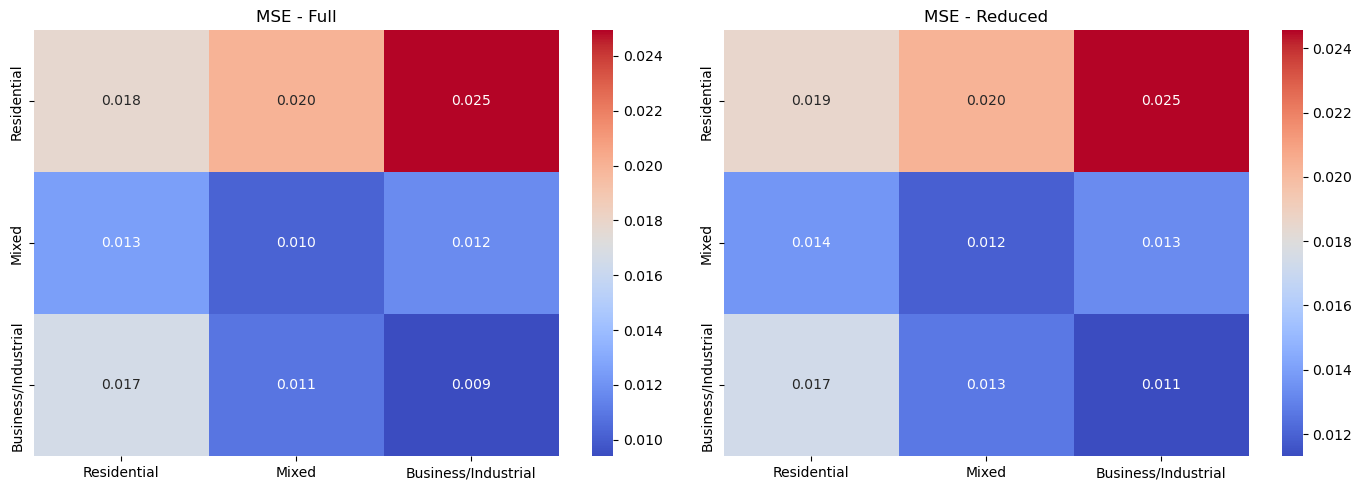

KMEANS - Correlation


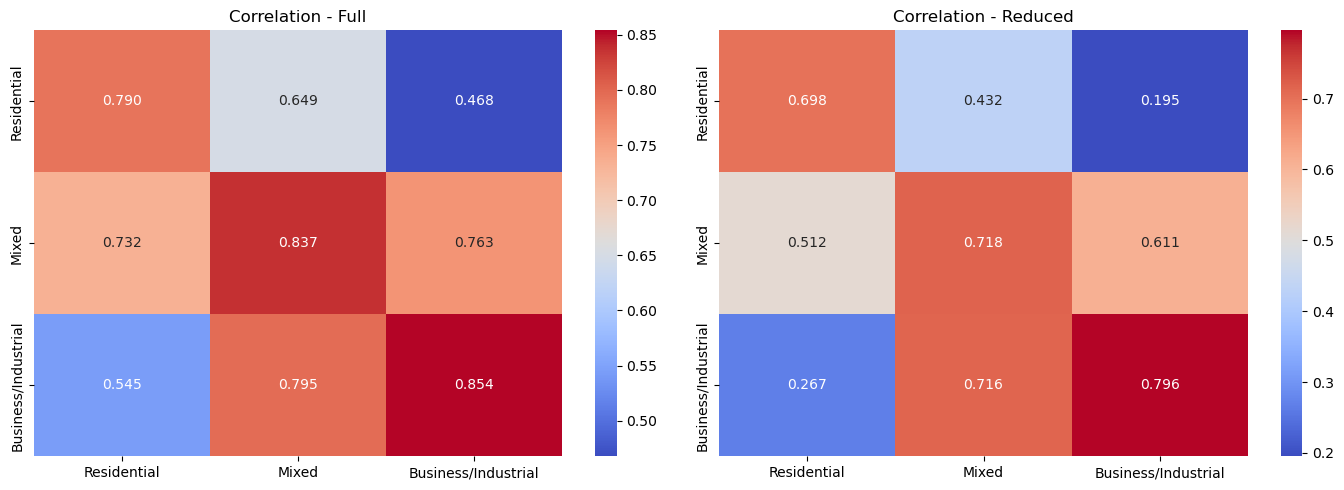

KMEANS - CosineSimilarity


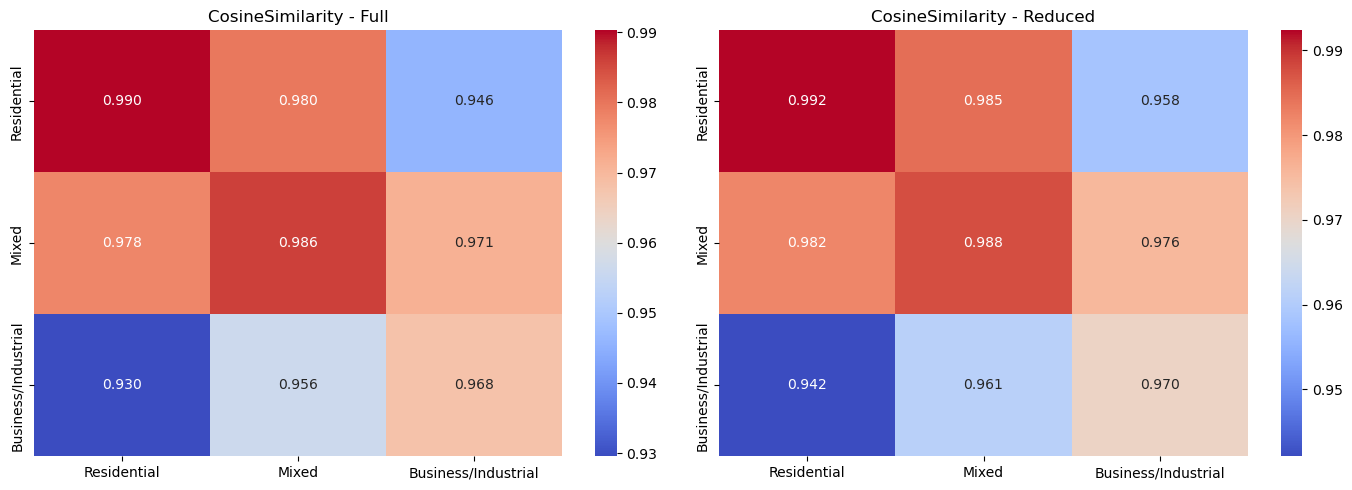

KMEANS - EuclideanDistance


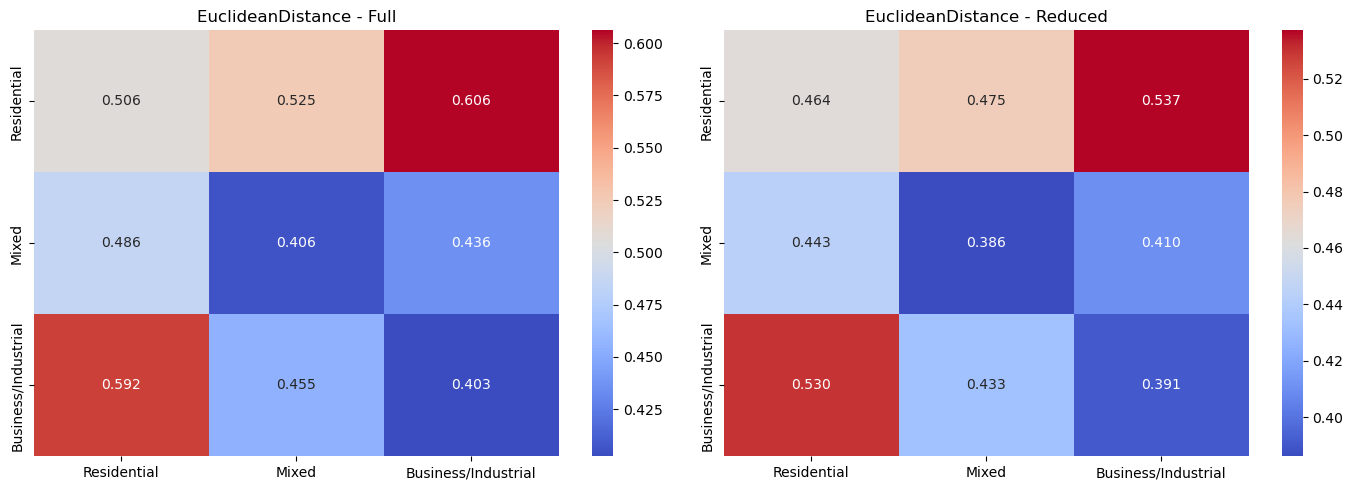

LSTM - MAE


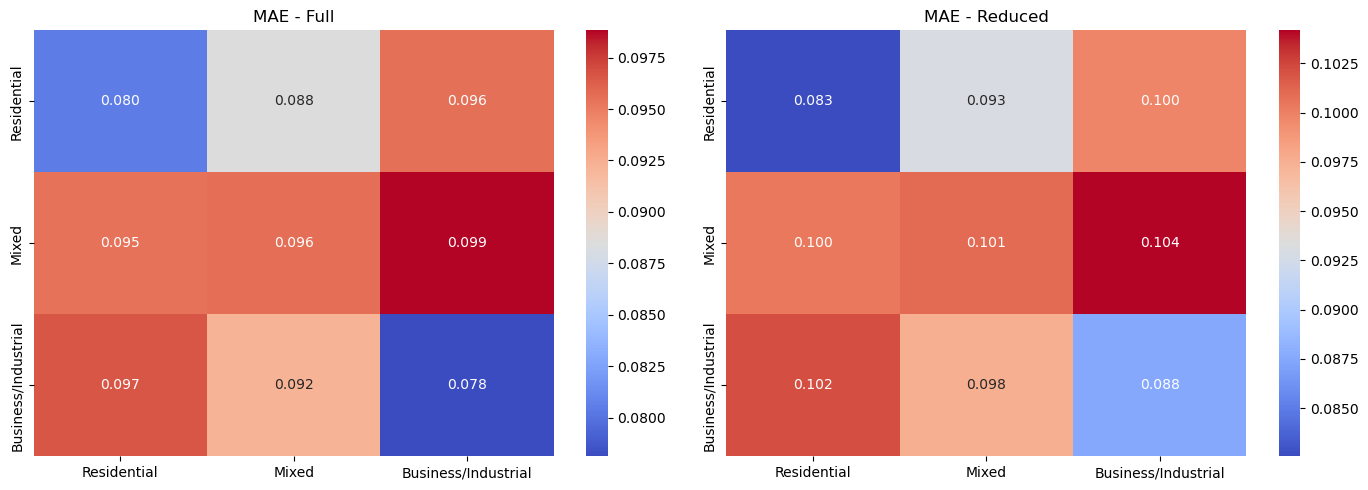

LSTM - RMSE


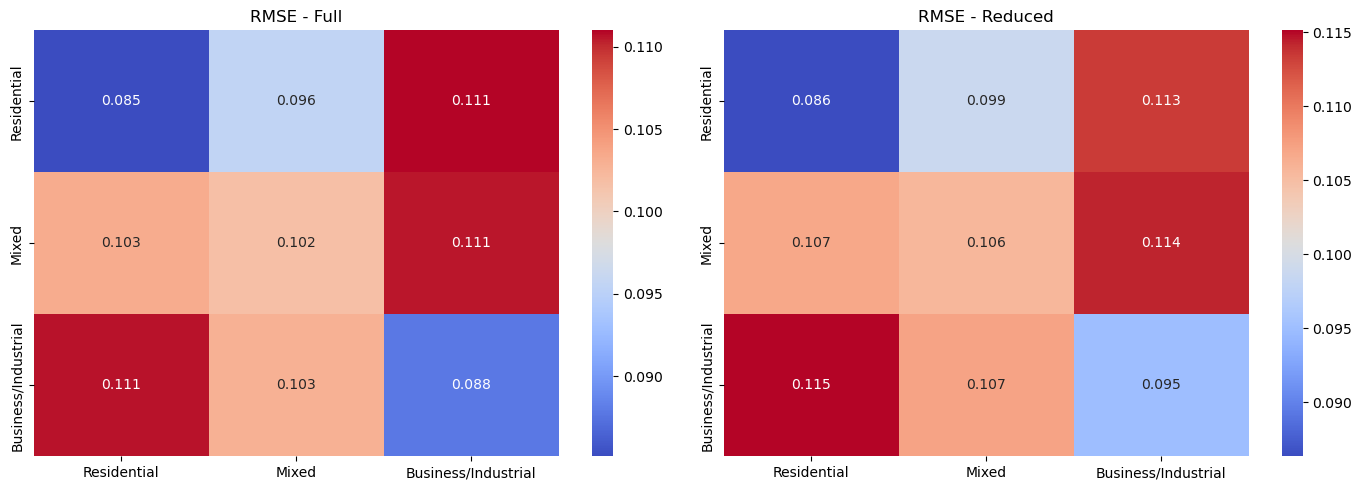

LSTM - MSE


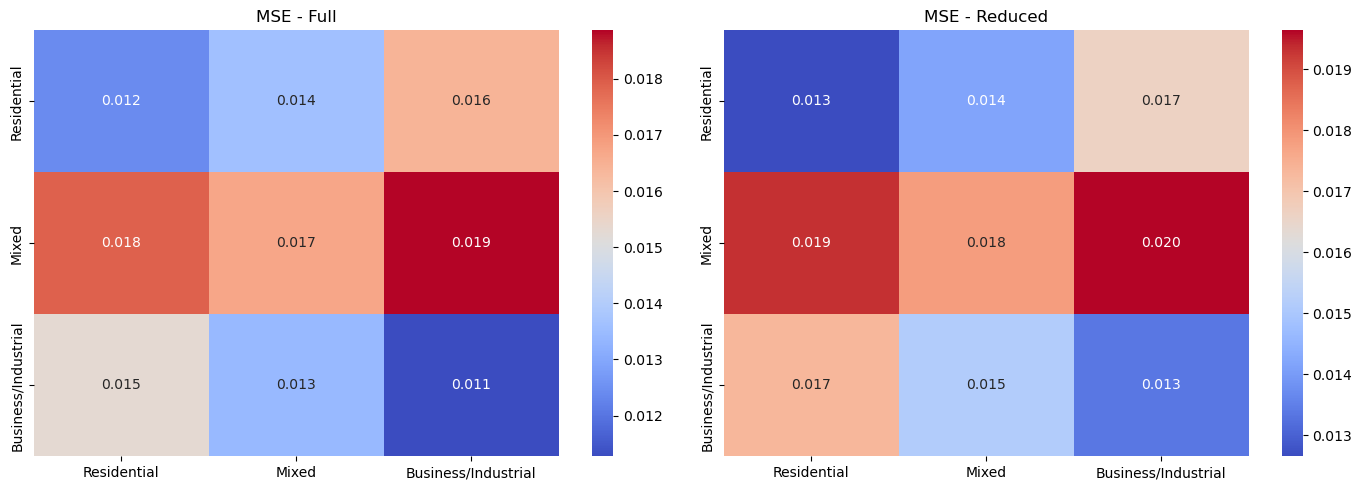

LSTM - Correlation


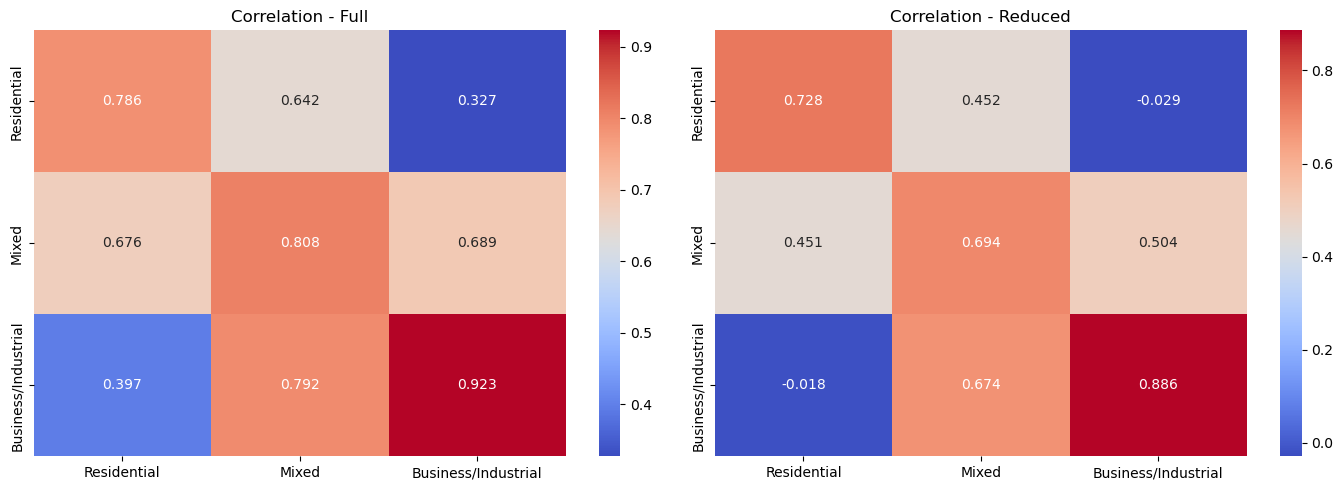

LSTM - CosineSimilarity


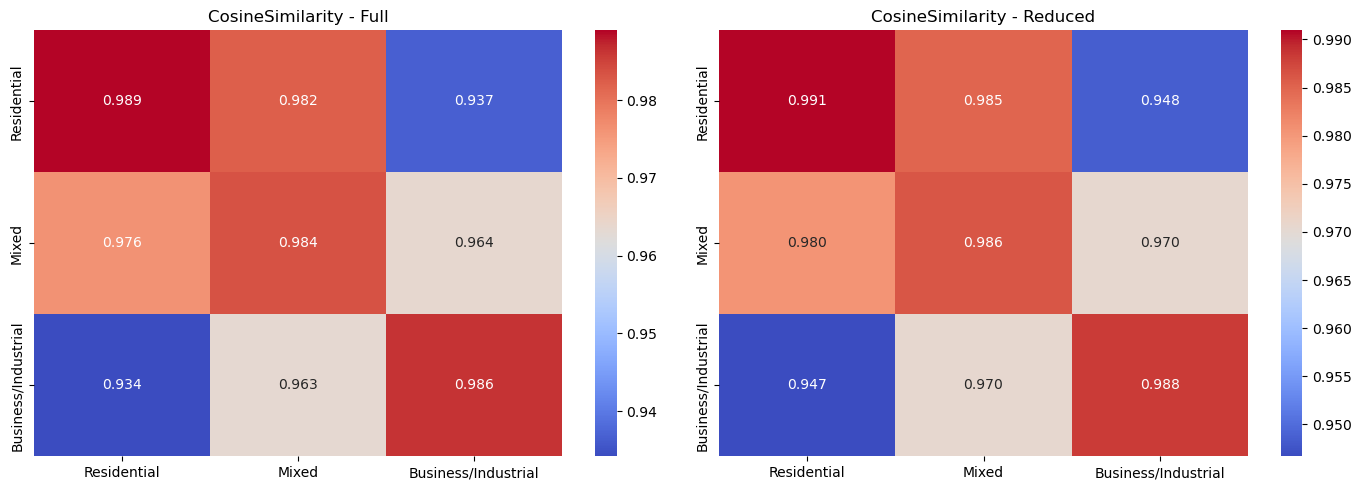

LSTM - EuclideanDistance


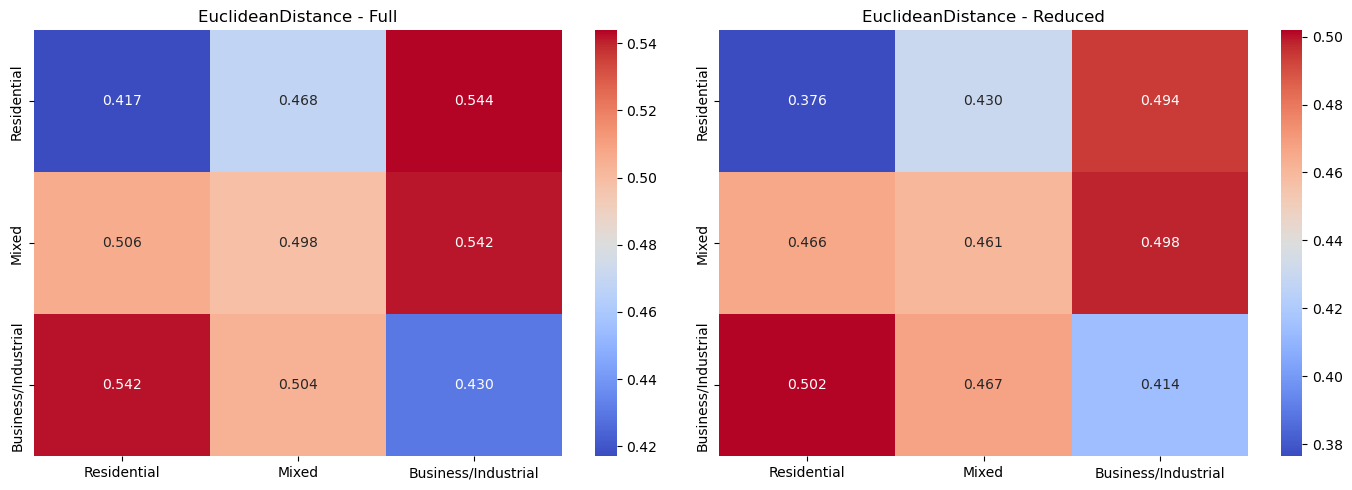

GRU - MAE


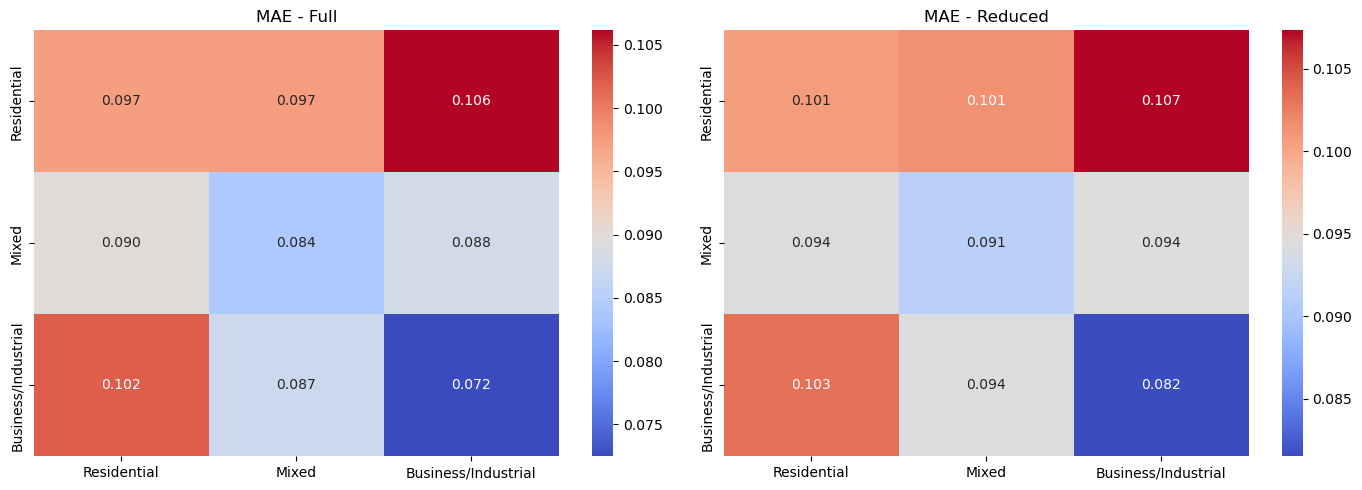

GRU - RMSE


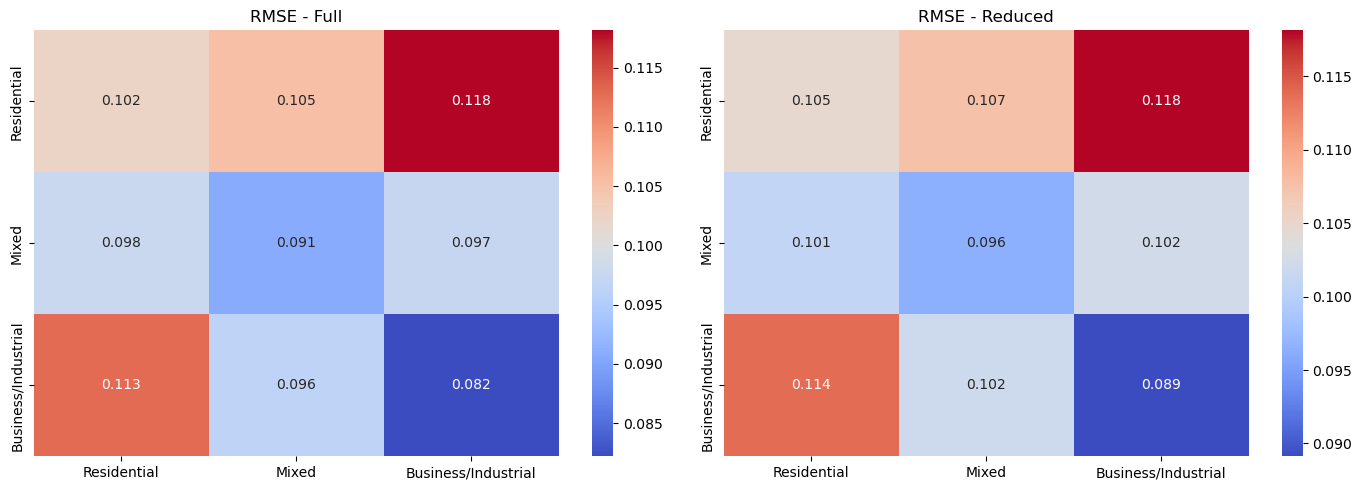

GRU - MSE


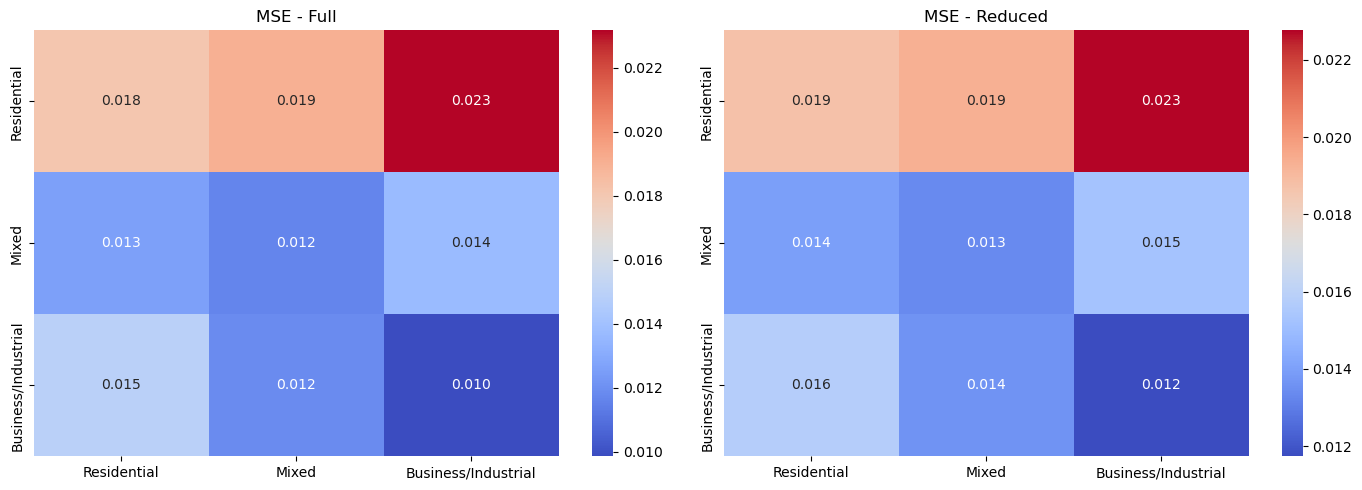

GRU - Correlation


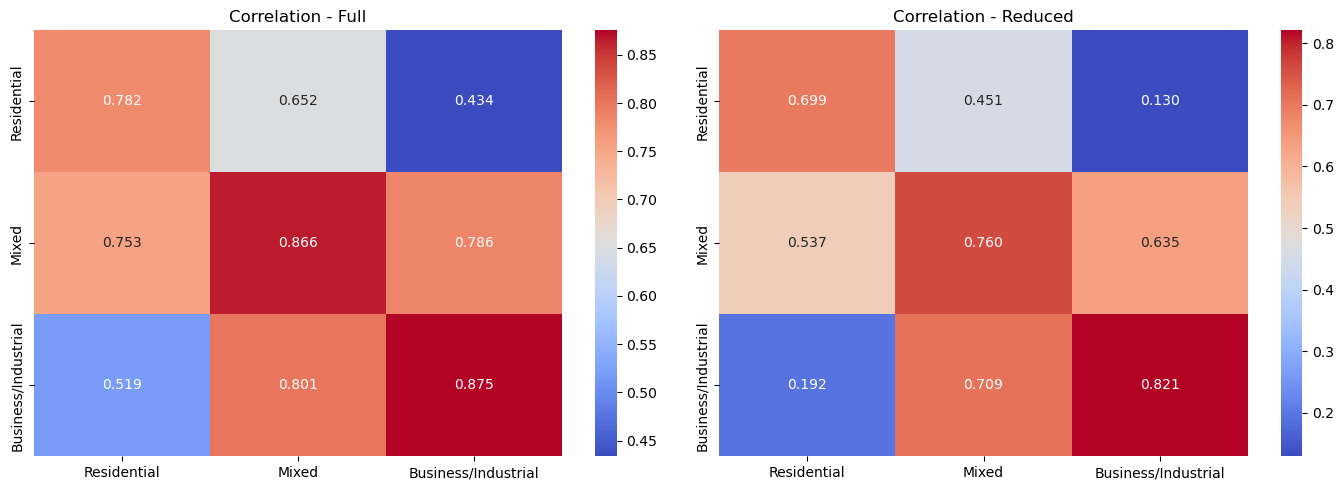

GRU - CosineSimilarity


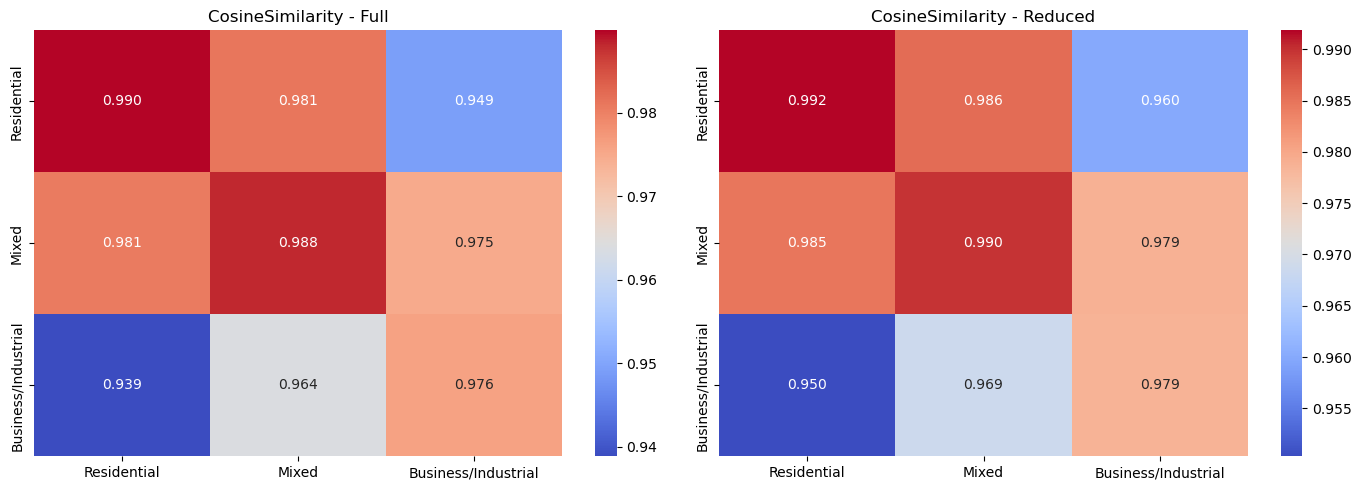

GRU - EuclideanDistance


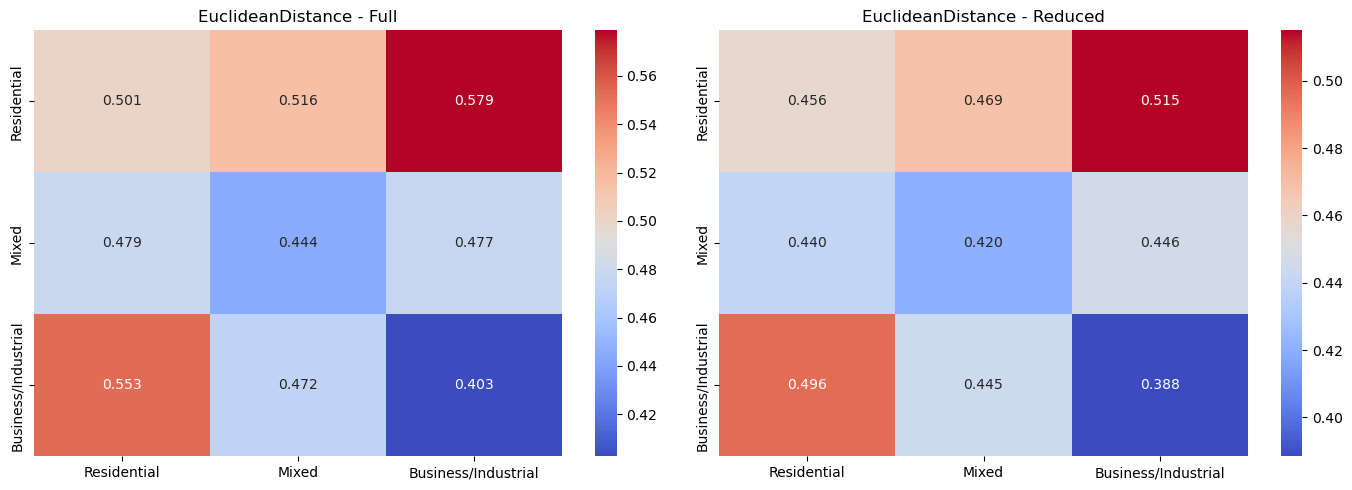

TCN - MAE


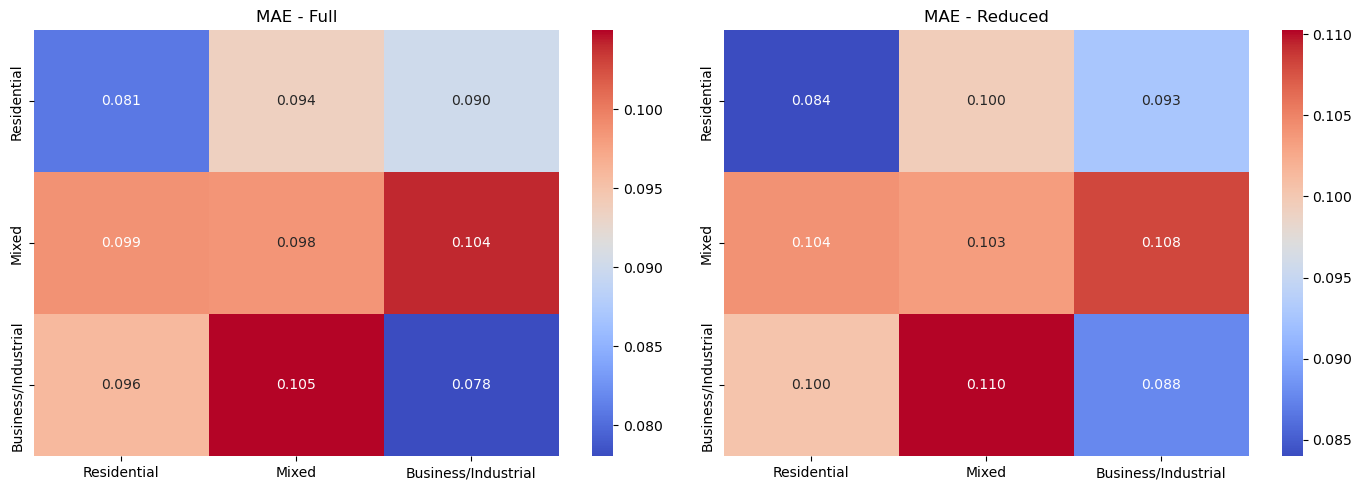

TCN - RMSE


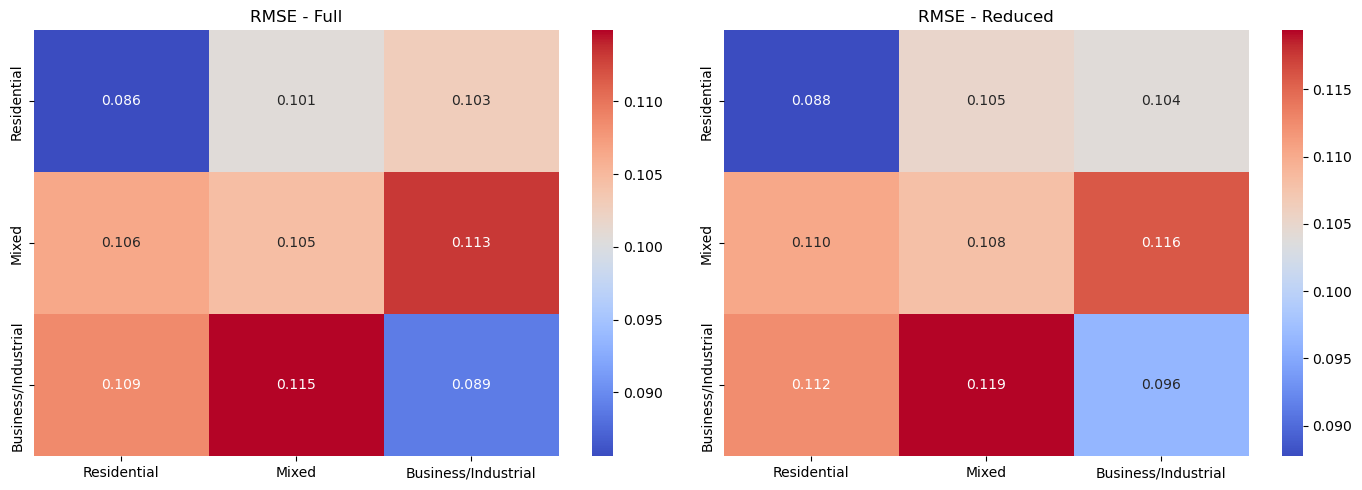

TCN - MSE


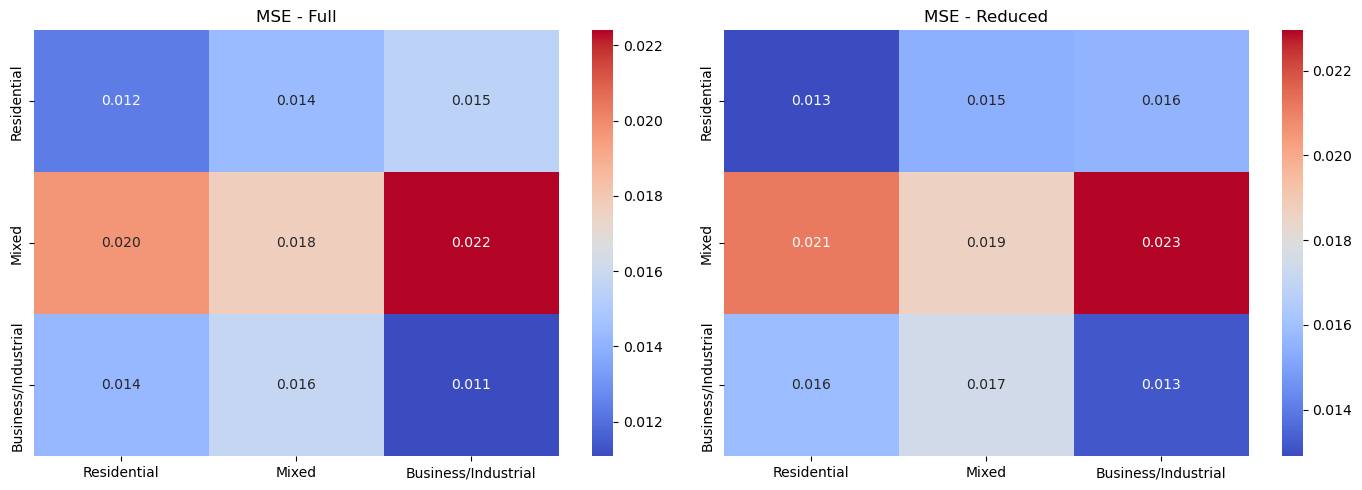

TCN - Correlation


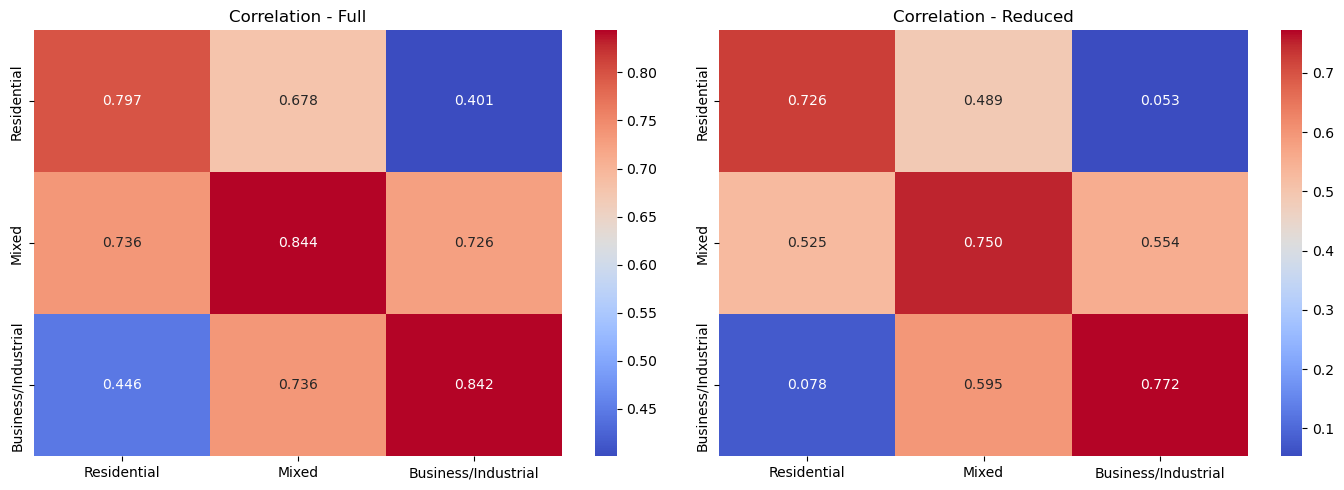

TCN - CosineSimilarity


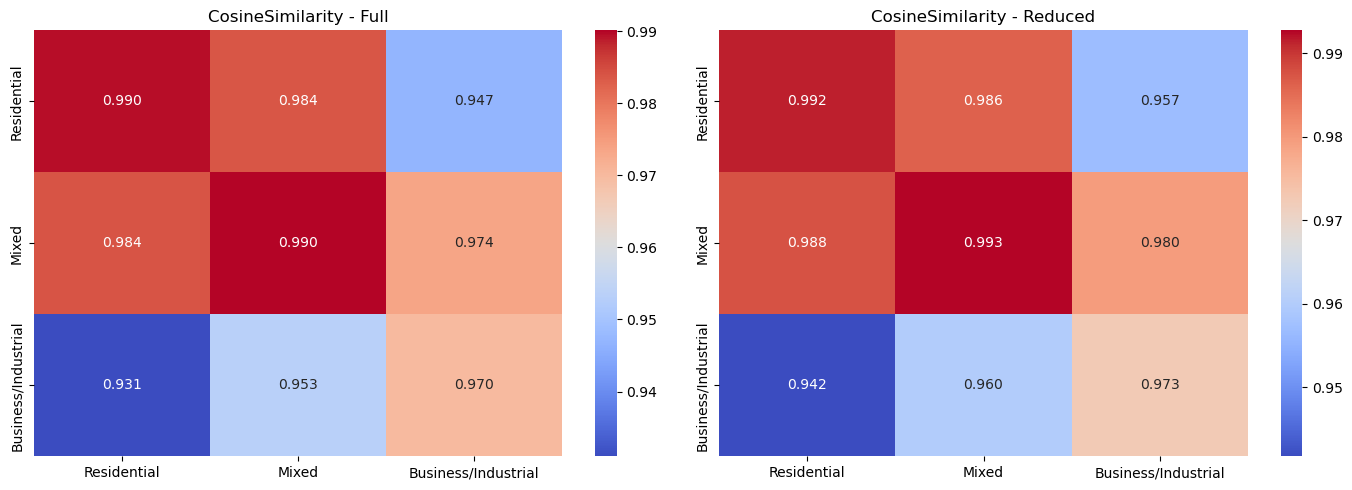

TCN - EuclideanDistance


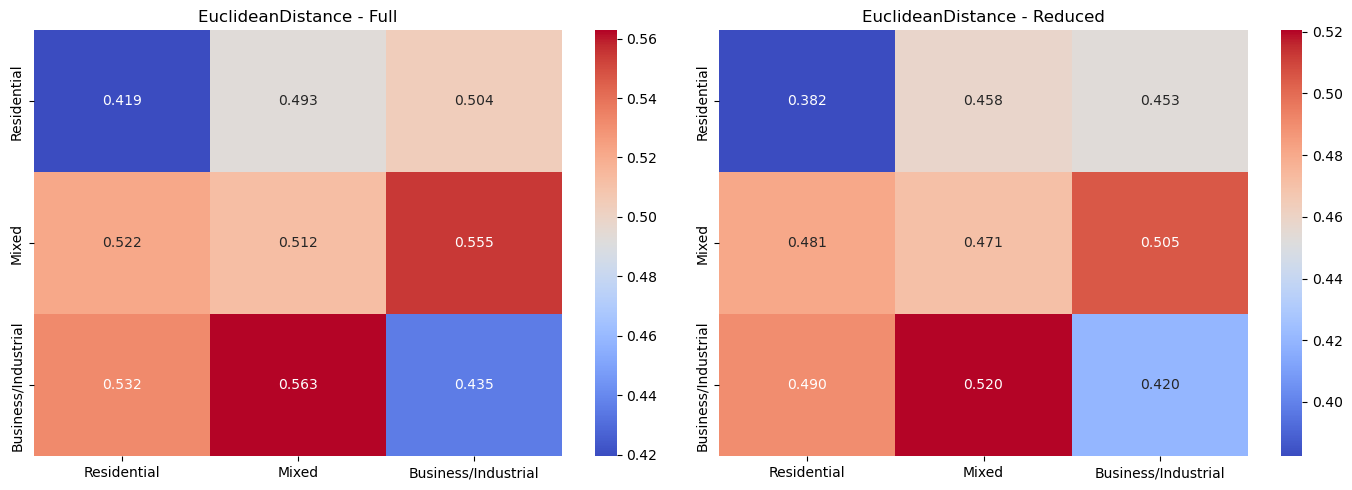

FINAL CLUSTER - MAE


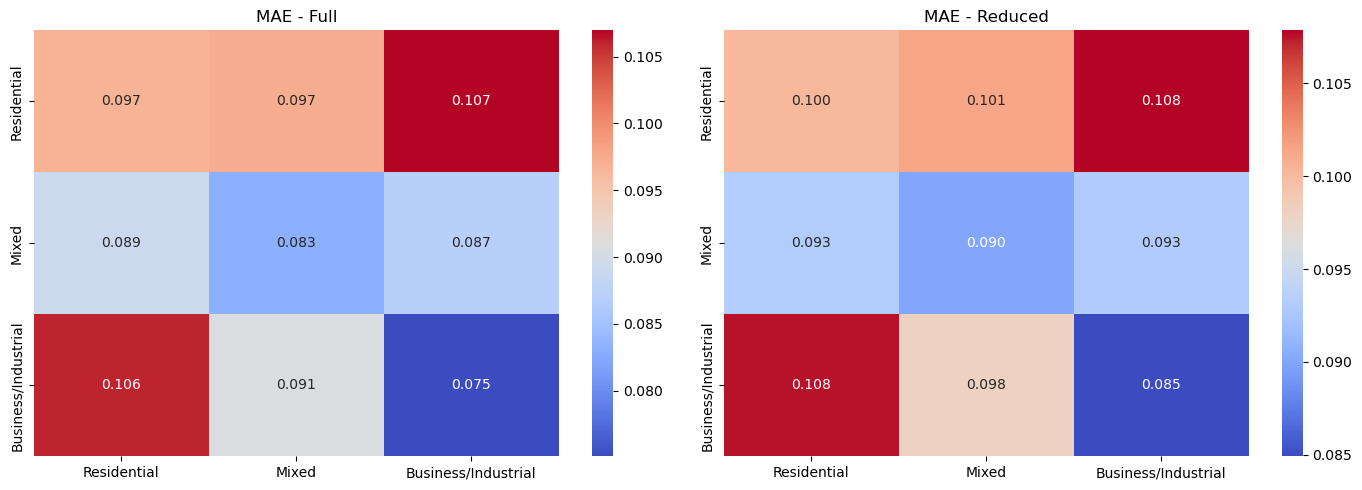

FINAL CLUSTER - RMSE


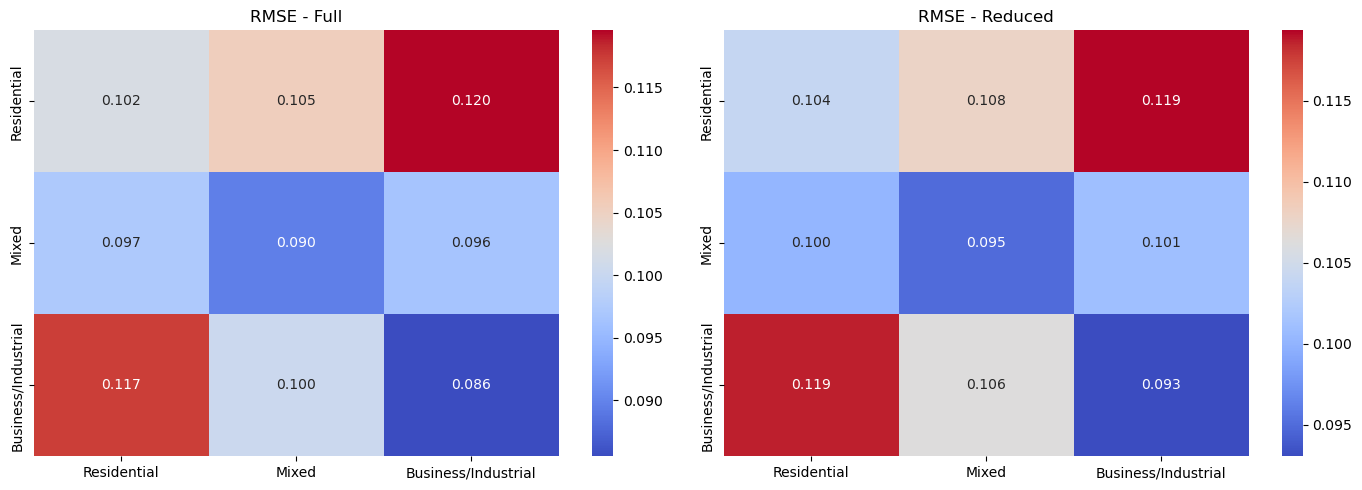

FINAL CLUSTER - MSE


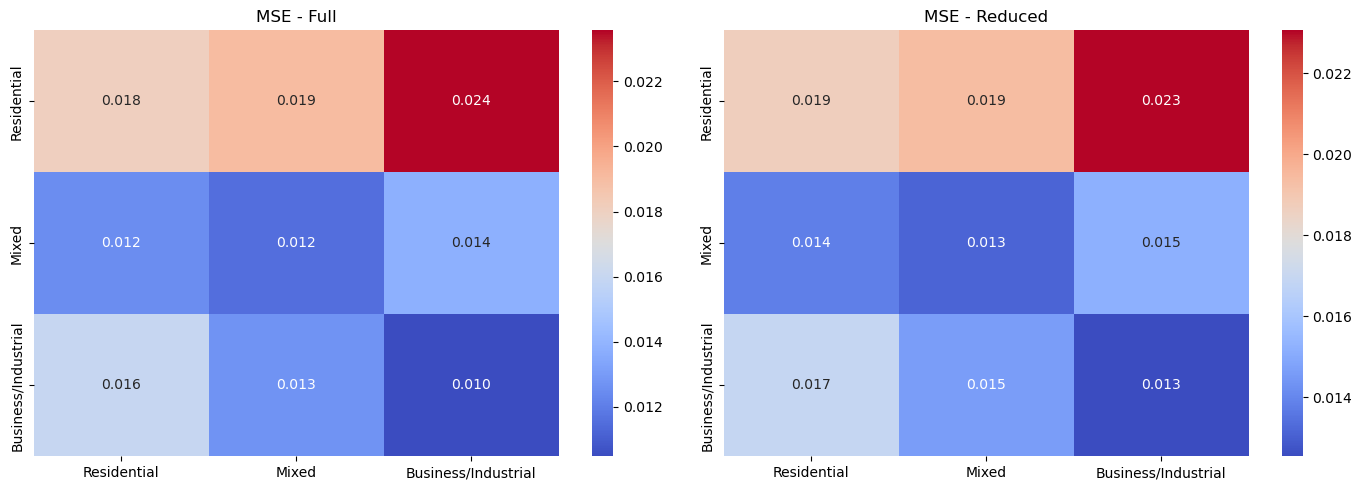

FINAL CLUSTER - Correlation


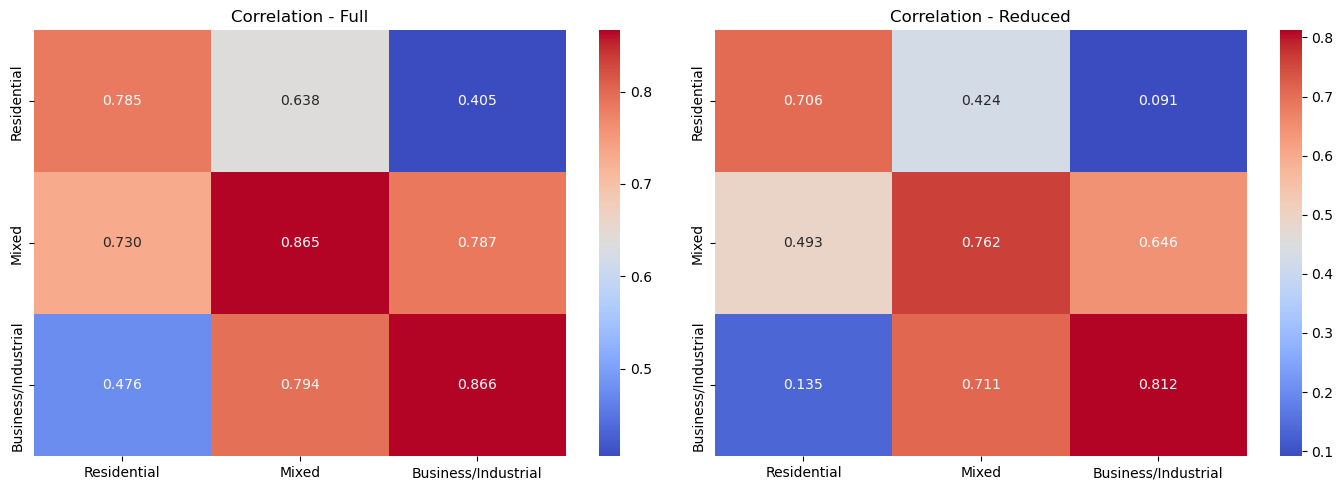

FINAL CLUSTER - CosineSimilarity


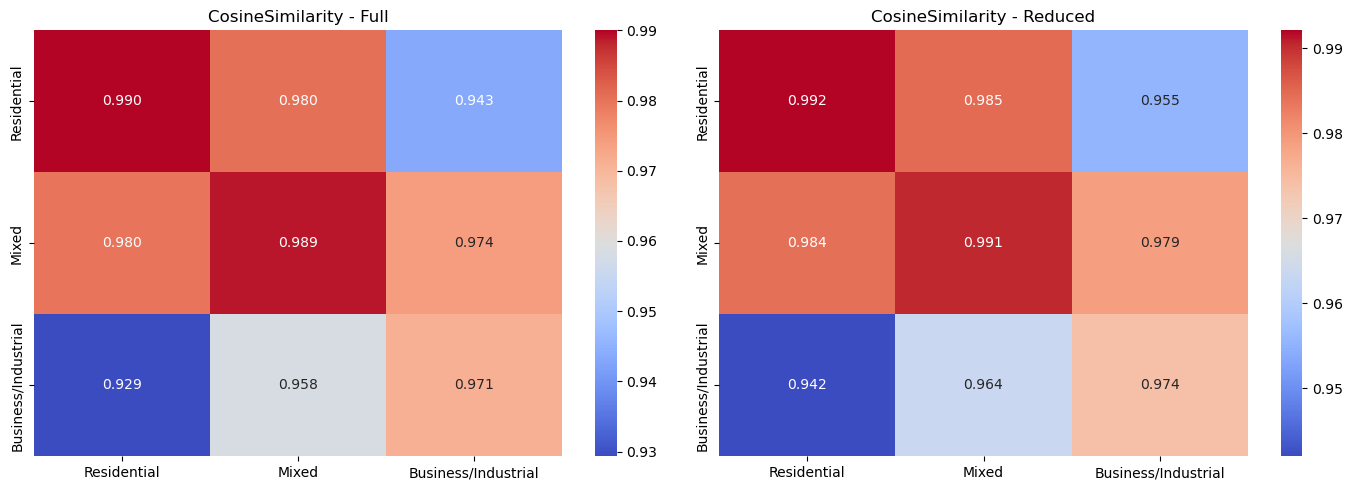

FINAL CLUSTER - EuclideanDistance


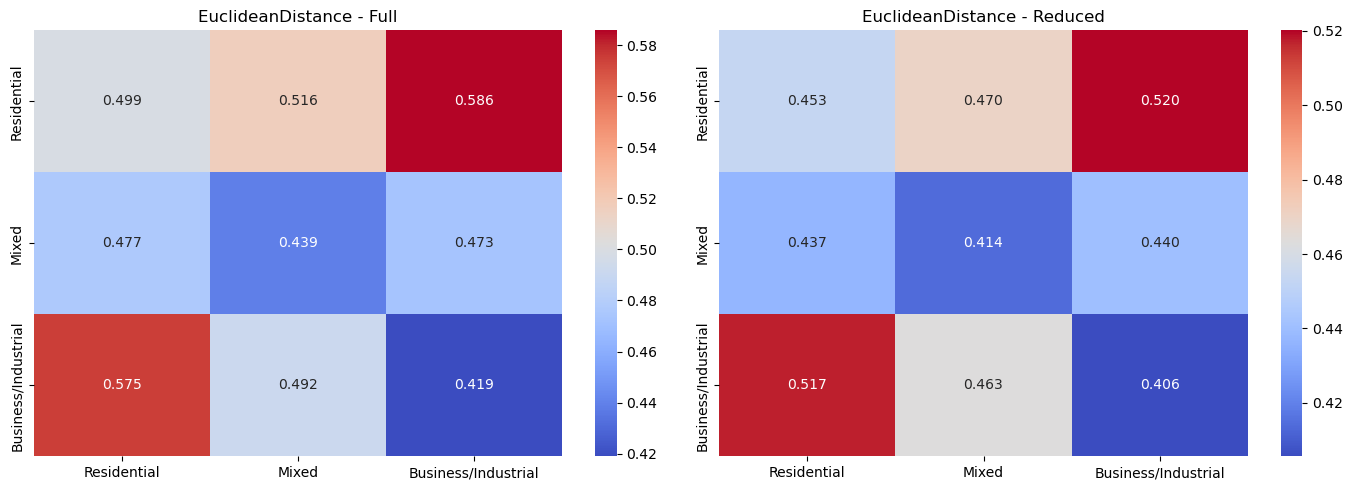

In [117]:
for model_name, result_set in all_results.items():
    full_metrics = result_set["Full 0–23"]
    reduced_metrics = result_set["Reduced 0–1 & 7–23"]

    for metric_name in full_metrics.keys():
        print(f"{model_name.upper()} - {metric_name}")
        plot_matrices_side_by_side(
            results_full=full_metrics,
            results_reduced=reduced_metrics,
            metric_name=metric_name,
            model_name=model_name,
            label_maps=custom_label_maps
        )
